Lnks to consider
1. Using integrated catboost trial pruner to stop bad trials in optune: https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_pruning.py

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import optuna.visualization as vis
from catboost import CatBoostClassifier
from catboost import Pool
from mrmr_wrapper import MRMRTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            roc_curve, precision_recall_curve, 
                            average_precision_score)

# Import and Prepare Data

In [2]:
# Load the data
file_path = "features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

# Create binary labels (1,2 = 0; 4,5 = 1; exclude 3 for clearer separation)
binary_labels = labels_shuffled.apply(lambda x: 0 if x <= 2 else (1 if x >=4 else np.nan))
binary_data = data_shuffled[~binary_labels.isna()]
binary_labels = binary_labels[~binary_labels.isna()] # The "~" operator is used to filter out NaN values (i.e., rows where Comfort Score == 3)

# Train/Test Split

In [3]:
# For binary classification
X_train, X_test, y_train, y_test = train_test_split(
    binary_data,
    binary_labels,
    test_size=0.2,
    stratify=binary_labels,
    random_state=42
)

# Optimize Feature Selection and Catboost Parameters

'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']), #https://catboost.ai/docs/en/concepts/algorithm-main-stages_bootstrap-options

'border_count': trial.suggest_int('border_count', 32, 255), This suggests to use 254 https://catboost.ai/docs/en/concepts/parameter-tuning

'eval_metric': trial.suggest_categorical('eval_metric', ['Logloss', 'CrossEntropy']), #https://catboost.ai/docs/en/concepts/loss-functions-classification#usage-information

'loss_function': trial.suggest_categorical('loss_function', ['Logloss', 'CrossEntropy']), #https://catboost.ai/docs/en/concepts/loss-functions-classification#usage-information

'subsample': trial.suggest_float('subsample', 0.05, 1.0), #https://catboost.ai/docs/en/references/training-parameters/common#eval_metric

'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 100), #https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/

'sampling_frequency': trial.suggest_categorical('sampling_frequency', ['PerTree', 'PerTreeLevel']), #https://catboost.ai/docs/en/references/training-parameters/common#eval_metric

'od_type': 'Iter', #https://catboost.ai/docs/en/features/overfitting-detector-desc

'od_wait': 50,

In [ ]:
X = X_train.copy()
y = y_train.copy()

def binary_classification_objective(trial):
    # Feature selection, only optimizing method and number of features (no hyperparameters of the methods)
    fs_method = trial.suggest_categorical('feature_selection', ['MRMR', 'RFE', 'None'])
    
    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step = 10) # Only allow a maximum of 105 features to be selected, with a step of 10, to go up to all features: X.shape[1]
        if fs_method == 'RFE':
            estimator = RandomForestClassifier()
            selector = RFE(estimator, n_features_to_select=k_features)
        else: #MRMR
            selector = MRMRTransformer(k_features=k_features) #https://feature-engine.trainindata.com/en/1.8.x/api_doc/selection/MRMR.html#feature_engine.selection.MRMR
    else:
        selector = 'passthrough'
    
    # CatBoost hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=25),
        'depth': trial.suggest_int('depth', 6, 10), #https://catboost.ai/docs/en/concepts/parameter-tuning
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True), #https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), 
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': False,
    }
    model = CatBoostClassifier(**params)

    # Pipeline
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"Error in trial: {e}")
        return -np.inf

# Run binary classification study
study = optuna.create_study(direction='maximize')
study.optimize(binary_classification_objective, n_trials=5, show_progress_bar=True)

# Print results
print("\nBinary Classification Optimization Results:")
print(f"Best Accuracy Score: {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-09-02 15:26:22,702] A new study created in memory with name: no-name-3e3fd6b9-21dc-43dd-9fcf-e1ebd270f8f3


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-09-02 15:26:55,353] Trial 0 finished with value: 0.7904663237996571 and parameters: {'feature_selection': 'None', 'iterations': 150, 'depth': 7, 'learning_rate': 0.004488966124965135, 'l2_leaf_reg': 3.7378707271610324e-06, 'random_strength': 0.07223132866741322, 'bagging_temperature': 0.07615716820578666, 'border_count': 238}. Best is trial 0 with value: 0.7904663237996571.
[I 2025-09-02 15:28:20,851] Trial 1 finished with value: 0.781329164662498 and parameters: {'feature_selection': 'None', 'iterations': 775, 'depth': 7, 'learning_rate': 0.010530333262995784, 'l2_leaf_reg': 2.1672960749463613e-07, 'random_strength': 1.5417271453212604e-08, 'bagging_temperature': 0.6772585144097765, 'border_count': 96}. Best is trial 0 with value: 0.7904663237996571.


100%|██████████| 105/105 [00:03<00:00, 26.99it/s]


Got MRMR features


100%|██████████| 105/105 [00:03<00:00, 26.92it/s]


Got MRMR features


100%|██████████| 105/105 [00:03<00:00, 27.16it/s]


Got MRMR features


100%|██████████| 105/105 [00:03<00:00, 27.27it/s]


Got MRMR features


100%|██████████| 105/105 [00:03<00:00, 26.96it/s]


Got MRMR features
[I 2025-09-02 15:29:13,031] Trial 2 finished with value: 0.7782223948890616 and parameters: {'feature_selection': 'MRMR', 'k_features': 105, 'iterations': 850, 'depth': 6, 'learning_rate': 0.004705927333988727, 'l2_leaf_reg': 0.14802378645353942, 'random_strength': 1.9294191086598634e-05, 'bagging_temperature': 0.18370185618749624, 'border_count': 183}. Best is trial 0 with value: 0.7904663237996571.
[I 2025-09-02 15:37:07,606] Trial 3 finished with value: 0.7873503040169707 and parameters: {'feature_selection': 'None', 'iterations': 525, 'depth': 9, 'learning_rate': 0.014339639186425657, 'l2_leaf_reg': 3.514041790136655, 'random_strength': 0.0002197396912054958, 'bagging_temperature': 0.3181811586758778, 'border_count': 249}. Best is trial 0 with value: 0.7904663237996571.
[I 2025-09-02 16:04:13,463] Trial 4 finished with value: 0.7922731589398255 and parameters: {'feature_selection': 'None', 'iterations': 1000, 'depth': 10, 'learning_rate': 0.007689353392449286, 'l2

# Additional Visualization

In [ ]:
# 1. Parameter Importance Plot
fig = vis.plot_param_importances(study, target_name="ROC AUC Score")
fig.show()

# 2. Slice Plot (Best for seeing individual parameter effects)
fig = vis.plot_slice(
    study,
    params=[
        'depth',
        'learning_rate',
        'k_features'
    ],
    target_name="ROC AUC Score"
)
fig.show()

# Apply Feature Selection to Training & Test Data

In [ ]:
# apply your feature selection code from before
best_fs_method = study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = study.best_params['k_features']
    if best_fs_method == 'RFE':
        estimator = RandomForestClassifier()
        selector = RFE(estimator)
    elif best_fs_method == 'MRMR':
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X, y)
    if hasattr(selector, 'get_support'):  # For RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMR
        selected_features = selector.selected_features
    X_best = X[selected_features]
else:
    X_best = X
    selected_features = X.columns

# Apply the same feature selection to test data
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test[selected_features]
    else:
        X_test_final = selector.transform(X_test)  # Use the already fitted selector
        if isinstance(X_test, pd.DataFrame):
            X_test_final = pd.DataFrame(X_test_final, columns=selected_features)
else:
    X_test_final = X_test

# Create Catboost Model with Optimized Parameters and Fit Model

border_count=254, # Suggested optimal value

eval_metric=study.best_params['eval_metric'],

loss_function=study.best_params['loss_function'],

subsample=study.best_params['subsample'],
    
sampling_frequency=study.best_params['sampling_frequency'],
    
min_data_in_leaf=study.best_params['min_data_in_leaf'],

In [7]:
best_model = CatBoostClassifier(
    iterations=study.best_params['iterations'],
    depth=study.best_params['depth'],
    learning_rate=study.best_params['learning_rate'],
    l2_leaf_reg= study.best_params['l2_leaf_reg'],
    random_strength=study.best_params['random_strength'],
    bagging_temperature=study.best_params['bagging_temperature'],
    border_count=study.best_params['border_count'],
    random_seed = 42,
    verbose=False
)

# Train on full imputed data
best_model.fit(X_best, y)
best_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 5.309771609063318e-07,
 'random_strength': 2.6437508040544344e-06,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 10,
 'posterior_sampling': False,
 'border_count': 148,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_sh

# Run Model and Get Outcomes


Final Model Evaluation on Test Set:
Accuracy: 0.6500
Precision: 0.6667
Recall: 0.7273
F1 Score: 0.6957
ROC AUC: 0.7475


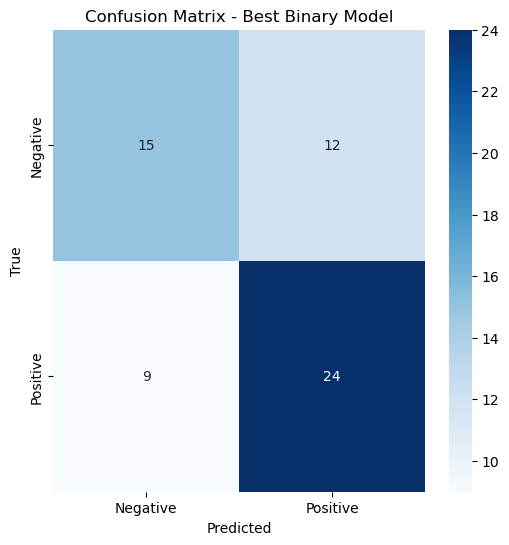

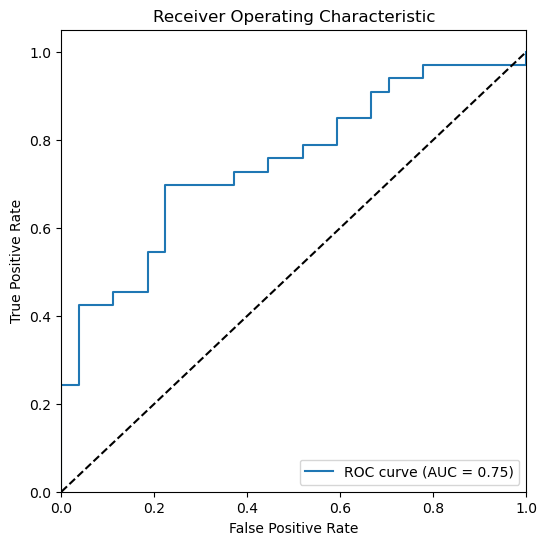

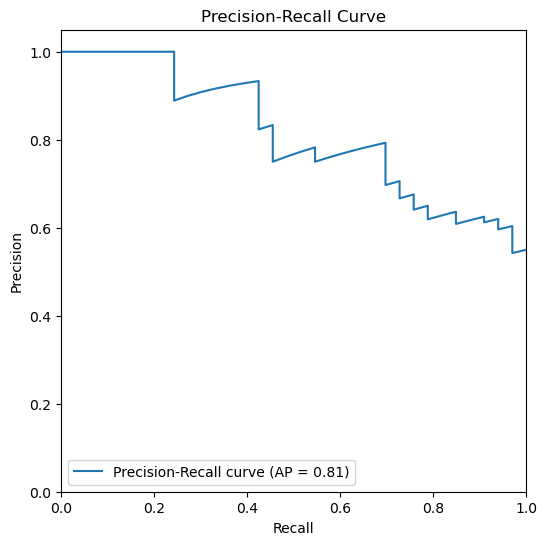

In [8]:
# Make predictions
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]  # Probabilities for class 1

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Binary Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Get Best Features
https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier_get_feature_importance

In [9]:
# Get importances
feature_importance_train = best_model.get_feature_importance(prettified=True)
feature_importance_test = best_model.get_feature_importance(data=Pool(X_test_final, label=y_test), prettified=True)

# Merge for comparison
importance_comparison = pd.merge(
    feature_importance_train.rename(columns={'Importances': 'Train_Importance'}),
    feature_importance_test.rename(columns={'Importances': 'Test_Importance'}),
    on='Feature Id',
    how='outer'
)

# Calculate difference
importance_comparison['Difference'] = importance_comparison['Train_Importance'] - importance_comparison['Test_Importance']
importance_comparison['Abs_Difference'] = abs(importance_comparison['Difference'])

print("Features with largest differences between train and test:")
print(importance_comparison.nlargest(10, 'Abs_Difference'))

Features with largest differences between train and test:
          Feature Id  Train_Importance  Test_Importance  Difference  \
148    O2_abs_fft_10          8.301839        11.035054   -2.733216   
127    O1_abs_fft_10          7.862358         6.048182    1.814176   
320         T8_alpha          3.665176         4.978607   -1.313431   
253    P8_abs_fft_10          1.873155         2.321697   -0.448543   
136   O1_norm_fft_10          3.423881         2.982408    0.441473   
129    O1_abs_fft_30          0.891117         0.499716    0.391402   
0             C3_SNR          1.034843         0.662078    0.372765   
284  PO7_norm_fft_20          3.013398         2.643017    0.370381   
10    C3_norm_fft_10          0.957108         0.589751    0.367357   
21            C4_SNR          1.749875         2.094730   -0.344855   

     Abs_Difference  
148        2.733216  
127        1.814176  
320        1.313431  
253        0.448543  
136        0.441473  
129        0.391402  
0     

# Calculate correlation (statistically) between test and train set top 10 features

In [ ]:
# Compare ranking correlation
train_ranks = feature_importance_train['Feature Id'].head(20).values
test_ranks = feature_importance_test['Feature Id'].head(20).values

# Calculate rank correlation
common_features = set(train_ranks) & set(test_ranks)
if len(common_features) >= 2:
    train_positions = [np.where(train_ranks == f)[0][0] for f in common_features]
    test_positions = [np.where(test_ranks == f)[0][0] for f in common_features]
    corr, p_value = spearmanr(train_positions, test_positions)
    print(f"Rank correlation: {corr:.3f} (p-value: {p_value:.3f})")

Rank correlation: 0.971 (p-value: 0.000)
